In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['pdf.fonttype'] = 42

## Logged dataset

In [3]:
from offsim4rl.utils.dataset_utils import load_h5_dataset
buffer = load_h5_dataset('../outputs/MyGridNaviCoords-v1_random.h5')
states_visited = buffer['observations']

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 34.35it/s]


In [4]:
_ = buffer['next_observations']
goal_states = _[(_>0.8).all(axis=1)]

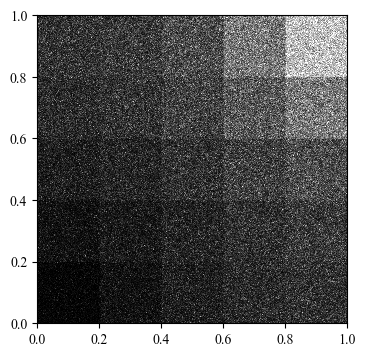

In [5]:
fig, ax = plt.subplots(figsize=(4,4))
plt.scatter(np.array(states_visited)[:, 0], np.array(states_visited)[:, 1], marker='.', alpha=0.2, c='k', lw=0, s=1)
plt.scatter(np.array(goal_states)[:, 0], np.array(goal_states)[:, 1], marker='.', alpha=0.2, c='k', lw=0, s=1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig('grid_state_visitation.png', dpi=600)
plt.savefig('grid_state_visitation.pdf')

## HOMER latent states

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args([])
args.seed = 0
args.latent_size = 50
args.hidden_size = 64
args.lr = 0.001
args.weight_decay = 0.0

category = 'both'
trial = '20220811T1457'
args.output_dir = "../../wip/output/" + f"./trial={trial},encoder_model={category},seed={args.seed}," + \
        f"dZ={args.latent_size},dH={args.hidden_size},lr={args.lr},weight_decay={args.weight_decay}/"

In [8]:
import os
from offsim4rl.encoders.homer import HOMEREncoder
homer_encoder = HOMEREncoder(
    obs_dim=2, action_dim=5,
    latent_size=args.latent_size,
    hidden_size=args.hidden_size,
    model_path=os.path.join(args.output_dir, 'encoder_model.pt'),
    log_dir=os.path.join(args.output_dir, 'logs'),
)

In [9]:
from offsim4rl.utils.vis_utils import plot_latent_state_color_map
x, y = np.meshgrid(np.arange(0, 1, 0.002), np.arange(0, 1, 0.002))
obs = torch.tensor(np.stack([x, y]).reshape((2, -1)).T, dtype=torch.float, device=homer_encoder.device)
emb = homer_encoder.encode(obs)
df_output = pd.DataFrame([(i, *x) for i, x in zip(emb, obs.cpu().numpy())], columns=['i', 'x', 'y'])

/home/t-stang/microsoft/rl-offline-simulation/offsim4rl/encoders/homer.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observations = torch.tensor(observations, dtype=torch.float, device=self.device)


In [10]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.6, high=1),
                          np.random.uniform(low=0.75, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

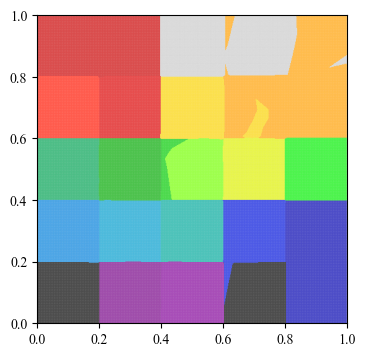

In [11]:
np.random.seed(1995)
ncolors = df_output['i'].nunique()
zz = list(range(ncolors))
# np.random.shuffle(zz)
df_output['z'] = df_output['i'].replace(df_output['i'].unique(), zz)

fig, ax = plt.subplots(figsize=(4,4))
plt.scatter(df_output['x'], df_output['y'], c=df_output['z'], 
            # cmap=rand_cmap(ncolors, type='bright', first_color_black=False, last_color_black=False, verbose=False), 
            cmap='nipy_spectral',
            marker='.', lw=0, s=1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig('grid_state_latent.png', dpi=600)
plt.savefig('grid_state_latent.pdf')

## Simulation results

In [12]:
dfs_real = [pd.read_csv(f'./outputs/grid_true/seed={seed}/progress.txt', sep='\t') for seed in range(10)]
df_real = pd.concat(dfs_real).groupby('Epoch').mean().reset_index()

In [13]:
dfs_homer50 = [pd.read_csv(f'./outputs/grid_psrs_homer50/seed={seed}/progress.txt', sep='\t') for seed in range(10)]
df_homer50 = pd.concat(dfs_homer50).groupby('Epoch').mean().reset_index()

In [14]:
dfs_psrs_oracle = [pd.read_csv(f'./outputs/grid_psrs_oracle/seed={seed}/progress.txt', sep='\t') for seed in range(10)]
df_psrs_oracle = pd.concat(dfs_psrs_oracle).groupby('Epoch').mean().reset_index()

In [15]:
dfs_baseline_obs_only = [pd.read_csv(f'./outputs/grid_psrs_baseline-obs-only/seed={seed}/progress.txt', sep='\t') for seed in range(10)]
df_baseline_obs_only = pd.concat(dfs_baseline_obs_only).groupby('Epoch').mean().reset_index()

In [16]:
dfs_baseline_act_only = [pd.read_csv(f'./outputs/grid_psrs_baseline-act-only/seed={seed}/progress.txt', sep='\t') for seed in range(10)]
df_baseline_act_only = pd.concat(dfs_baseline_act_only).groupby('Epoch').mean().reset_index()

In [17]:
dfs_baseline_random = [pd.read_csv(f'./outputs/grid_psrs_baseline-random/seed={seed}/progress.txt', sep='\t') for seed in range(10)]
df_baseline_random = pd.concat(dfs_baseline_random).groupby('Epoch').mean().reset_index()

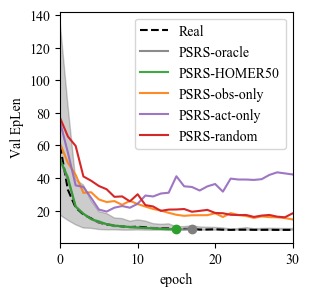

In [18]:
fig, ax = plt.subplots(figsize=(3,3))

col_name = 'AverageVal_EpLen'

plt.plot(df_real[col_name], color='k', ls='--', label='Real')
plt.fill_between(df_real['Epoch'], df_real[col_name.replace('Average', 'Min')], df_real[col_name.replace('Average', 'Max')], alpha=0.2, color='k')

plt.plot(df_psrs_oracle[col_name], lw=1.5, alpha=0.9, label='PSRS-oracle', c='tab:gray')
plt.scatter(len(df_psrs_oracle[col_name])-1, df_psrs_oracle[col_name].iloc[-1], marker='o', color=plt.gca().lines[-1].get_color(), alpha=1, zorder=11)

plt.plot(df_homer50[col_name], lw=1.5, alpha=0.9, label='PSRS-HOMER50', c='tab:green')
plt.scatter(len(df_homer50[col_name])-1, df_homer50[col_name].iloc[-1], marker='o', color=plt.gca().lines[-1].get_color(), alpha=1, zorder=11)

plt.plot(df_baseline_obs_only[col_name], lw=1.5, alpha=0.9, label='PSRS-obs-only', c='tab:orange')
plt.scatter(len(df_baseline_obs_only[col_name])-1, df_baseline_obs_only[col_name].iloc[-1], 
            marker='o', color=plt.gca().lines[-1].get_color(), alpha=1, zorder=11)

plt.plot(df_baseline_act_only[col_name], lw=1.5, alpha=0.9, label='PSRS-act-only', c='tab:purple')
plt.scatter(len(df_baseline_act_only[col_name])-1, df_baseline_act_only[col_name].iloc[-1], 
            marker='o', color=plt.gca().lines[-1].get_color(), alpha=1, zorder=11)

plt.plot(df_baseline_random[col_name], lw=1.5, alpha=1, label='PSRS-random', c='tab:red')
plt.scatter(len(df_baseline_random[col_name])-1, df_baseline_random[col_name].iloc[-1], 
            marker='o', color=plt.gca().lines[-1].get_color(), alpha=1, zorder=11)

plt.xlabel('epoch')
plt.ylabel('Val EpLen')
plt.xlim(0,30)
plt.legend()
# plt.savefig('grid_ppo_FINAL.pdf', bbox_inches='tight')
plt.show()

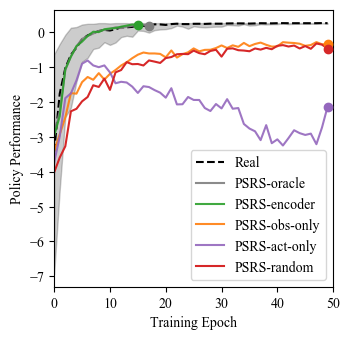

In [24]:
fig, ax = plt.subplots(figsize=(3.6, 3.6))

col_name = 'AverageVal_EpRet'

plt.plot(df_real[col_name], color='k', ls='--', label='Real')
plt.fill_between(df_real['Epoch'], df_real[col_name.replace('Average', 'Min')], df_real[col_name.replace('Average', 'Max')], alpha=0.2, color='k')

plt.plot(df_psrs_oracle[col_name], lw=1.5, alpha=0.9, label='PSRS-oracle', c='tab:gray')
plt.scatter(len(df_psrs_oracle[col_name])-1, df_psrs_oracle[col_name].iloc[-1], marker='o', color=plt.gca().lines[-1].get_color(), alpha=1, zorder=11)

# plt.plot(df_dummy['AverageVal_EpLen'], lw=1.5, alpha=1, label='PSRS-dummy', c='tab:purple')
# plt.scatter(len(df_dummy['AverageVal_EpLen'])-1, df_dummy['AverageVal_EpLen'].iloc[-1], marker='o', color=plt.gca().lines[-1].get_color(), alpha=1, zorder=11)

plt.plot(df_homer50[col_name], lw=1.5, alpha=0.9, label='PSRS-encoder', c='tab:green')
plt.scatter(len(df_homer50[col_name])-1, df_homer50[col_name].iloc[-1], marker='o', color=plt.gca().lines[-1].get_color(), alpha=1, zorder=11)

plt.plot(df_baseline_obs_only[col_name], lw=1.5, alpha=0.9, label='PSRS-obs-only', c='tab:orange')
plt.scatter(len(df_baseline_obs_only[col_name])-1, df_baseline_obs_only[col_name].iloc[-1], 
            marker='o', color=plt.gca().lines[-1].get_color(), alpha=1, zorder=11)

plt.plot(df_baseline_act_only[col_name], lw=1.5, alpha=0.9, label='PSRS-act-only', c='tab:purple')
plt.scatter(len(df_baseline_act_only[col_name])-1, df_baseline_act_only[col_name].iloc[-1], 
            marker='o', color=plt.gca().lines[-1].get_color(), alpha=1, zorder=11)

plt.plot(df_baseline_random[col_name], lw=1.5, alpha=1, label='PSRS-random', c='tab:red')
plt.scatter(len(df_baseline_random[col_name])-1, df_baseline_random[col_name].iloc[-1], 
            marker='o', color=plt.gca().lines[-1].get_color(), alpha=1, zorder=11)

plt.xlabel('Training Epoch')
plt.ylabel('Policy Performance')
plt.xlim(0,50)
plt.legend(loc='lower right')
plt.savefig('grid_ppo_FINAL.pdf', bbox_inches='tight')
plt.show()

In [20]:
T = int(np.median([len(df) for df in dfs_homer50]))

In [21]:
col_name = 'AverageVal_EpRet'

In [22]:
for name_sim, df_sim, dfs_sim in zip(
    ['Real', 'oracle', 'HOMER50', 'obs', 'act', 'random'],
    [df_real, df_psrs_oracle, df_homer50, df_baseline_obs_only, df_baseline_act_only, df_baseline_random], 
    [dfs_real, dfs_psrs_oracle, dfs_homer50, dfs_baseline_obs_only, dfs_baseline_act_only, dfs_baseline_random], 
):
    print(
        name_sim, 
        int(np.median([len(df) for df in dfs_sim])),
        '{:.3f}'.format(
            np.sqrt(np.mean(np.square(
                df_sim[col_name][:T] - df_real[col_name][:T])))
        )
    )

Real 50 0.000
oracle 17 0.173
HOMER50 16 0.203
obs 50 1.148
act 50 1.221
random 50 1.514
